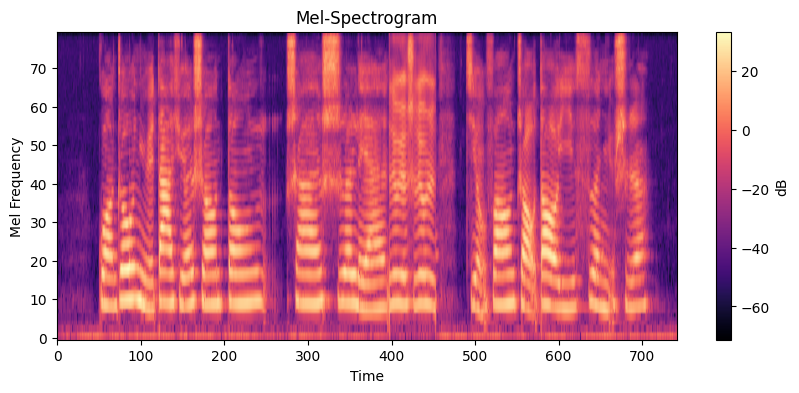

In [12]:
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt

file_path = "D:/Projects/AudioForgery/HAD/HAD_train/conbine/HAD_train_fake_00000001.wav"
waveform, sample_rate = torchaudio.load(file_path)

n_mels = 80
mel_spectrogram_transform = T.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels)
mel_spec = mel_spectrogram_transform(waveform)

mel_spec_db = T.AmplitudeToDB()(mel_spec)

plt.figure(figsize=(10, 4))
plt.imshow(mel_spec_db.squeeze().numpy(), aspect="auto", origin="lower", cmap="magma")
plt.colorbar(label="dB")
plt.title("Mel-Spectrogram")
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.show()

In [16]:
import torch
import torch.nn as nn
import timm

class Res2Net50(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model("res2net50_26w_4s", pretrained=False, num_classes=2)

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Res2Net50().to(device)

print("Res2Net50 model ready!")

Res2Net50 model ready!


In [30]:
import torchaudio.transforms as T
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os

class AudioDataset(Dataset):
    def __init__(self, fake_dir, real_dir, sample_rate=22050, n_mels=128, max_width=224):
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.max_width = max_width
        
        self.mel_transform = T.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels, n_fft=1024)
        self.normalize = transforms.Normalize(mean=[0.5], std=[0.5])

        self.data = []
        for file in os.listdir(fake_dir):
            if file.endswith(".wav"):
                self.data.append((os.path.join(fake_dir, file), 1))
        for file in os.listdir(real_dir):
            if file.endswith(".wav"):
                self.data.append((os.path.join(real_dir, file), 0))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx]

        waveform, sr = torchaudio.load(file_path)

        if sr != self.sample_rate:
            resampler = T.Resample(orig_freq=sr, new_freq=self.sample_rate)
            waveform = resampler(waveform)

        mel_spec = self.mel_transform(waveform)
        mel_spec = torch.log(mel_spec + 1e-6)

        
        _, mel_height, mel_width = mel_spec.shape
        if mel_width < self.max_width:
            mel_spec = torch.nn.functional.pad(mel_spec, (0, self.max_width - mel_width))
        else:
            mel_spec = mel_spec[:, :, :self.max_width]

        mel_spec = self.normalize(mel_spec)

        mel_spec = mel_spec.repeat(3, 1, 1)

        return mel_spec, torch.tensor(label, dtype=torch.long)

In [32]:
fake_dir = r"D:\Projects\AudioForgery\HAD\HAD_train\1000Fakes"
real_dir = r"D:\Projects\AudioForgery\HAD\HAD_train\1000Real"

dataset = AudioDataset(fake_dir, real_dir)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

print("DataLoader is ready!")


DataLoader is ready!


In [34]:
import torch.optim as optim
import time
from tqdm import tqdm

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    start_time = time.time()

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for mel_specs, labels in progress_bar:
        mel_specs, labels = mel_specs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(mel_specs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    end_time = time.time()
    avg_loss = total_loss / len(dataloader)
    epoch_time = end_time - start_time

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Time: {epoch_time:.2f} sec")

print("Training complete! ✅")


Epoch 1/10: 100%|██████████| 125/125 [04:15<00:00,  2.04s/it, loss=0.1241]


Epoch [1/10] | Loss: 0.3653 | Time: 255.17 sec


Epoch 2/10: 100%|██████████| 125/125 [04:12<00:00,  2.02s/it, loss=0.2389]


Epoch [2/10] | Loss: 0.2314 | Time: 252.36 sec


Epoch 3/10: 100%|██████████| 125/125 [04:12<00:00,  2.02s/it, loss=0.3369]


Epoch [3/10] | Loss: 0.1445 | Time: 252.15 sec


Epoch 4/10: 100%|██████████| 125/125 [03:59<00:00,  1.91s/it, loss=0.1426]


Epoch [4/10] | Loss: 0.0883 | Time: 239.36 sec


Epoch 5/10: 100%|██████████| 125/125 [04:01<00:00,  1.93s/it, loss=0.4171]


Epoch [5/10] | Loss: 0.0572 | Time: 241.15 sec


Epoch 6/10: 100%|██████████| 125/125 [04:11<00:00,  2.01s/it, loss=0.0166]


Epoch [6/10] | Loss: 0.0442 | Time: 251.60 sec


Epoch 7/10: 100%|██████████| 125/125 [04:25<00:00,  2.13s/it, loss=0.0050]


Epoch [7/10] | Loss: 0.0317 | Time: 265.87 sec


Epoch 8/10: 100%|██████████| 125/125 [04:17<00:00,  2.06s/it, loss=0.0030]


Epoch [8/10] | Loss: 0.0330 | Time: 258.00 sec


Epoch 9/10: 100%|██████████| 125/125 [04:34<00:00,  2.19s/it, loss=0.0013]


Epoch [9/10] | Loss: 0.0303 | Time: 274.27 sec


Epoch 10/10: 100%|██████████| 125/125 [04:06<00:00,  1.97s/it, loss=0.0952]

Epoch [10/10] | Loss: 0.0177 | Time: 246.45 sec
Training complete! 


In [36]:
torch.save(model.state_dict(), "res2net50_audio_classifier.pth")
print("Model saved as res2net50_audio_classifier.pth ")

Model saved as res2net50_audio_classifier.pth 


In [38]:
def predict_audio(model, file_path):
    model.eval()
    
    waveform, sr = torchaudio.load(file_path)

    target_sr = 22050
    if sr != target_sr:
        resampler = T.Resample(orig_freq=sr, new_freq=target_sr)
        waveform = resampler(waveform)

    mel_transform = T.MelSpectrogram(sample_rate=target_sr, n_mels=128, n_fft=1024)
    mel_spec = mel_transform(waveform)
    mel_spec = torch.log(mel_spec + 1e-6)

    max_width = 224
    _, mel_height, mel_width = mel_spec.shape
    if mel_width < max_width:
        mel_spec = torch.nn.functional.pad(mel_spec, (0, max_width - mel_width))
    else:
        mel_spec = mel_spec[:, :, :max_width]

    normalize = transforms.Normalize(mean=[0.5], std=[0.5])
    mel_spec = normalize(mel_spec)

    mel_spec = mel_spec.repeat(3, 1, 1)

    mel_spec = mel_spec.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(mel_spec)
        prediction = torch.argmax(output, dim=1).item()

    label = "Fake" if prediction == 1 else "Real"
    print(f"Prediction: {label} ")

test_file = "D:/Projects/AudioForgery/HAD/HAD_train/conbine/HAD_train_fake_00001001.wav" 
predict_audio(model, test_file)

Prediction: Fake 


In [96]:
test_file = "D:/Projects/AudioForgery/HAD/HAD_train/conbine/HAD_train_real_00001222.wav" 
predict_audio(model, test_file)

Prediction: Real 


In [100]:
test_file = "D:/Projects/AudioForgery/HAD/HAD_train/conbine/HAD_train_real_00001222.wav" 
predict_audio(model, test_file)

Prediction: Real 


In [102]:
test_file = "D:/Projects/AudioForgery/HAD/HAD_train/conbine/HAD_train_fake_00009399.wav" 
predict_audio(model, test_file)

Prediction: Fake 


In [106]:
test_file = "D:/Projects/AudioForgery/HAD/HAD_train/conbine/HAD_train_real_00006062.wav" 
predict_audio(model, test_file)

Prediction: Fake 


In [110]:
test_file = "D:/Projects/AudioForgery/HAD/HAD_train/conbine/HAD_train_real_00006110.wav" 
predict_audio(model, test_file)

Prediction: Fake 


In [112]:
test_file = "D:/Projects/AudioForgery/HAD/HAD_train/conbine/HAD_train_fake_00006110.wav" 
predict_audio(model, test_file)

Prediction: Fake 
